In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.cuda.get_device_name(0)

'NVIDIA A100-PCIE-40GB'

In [4]:
torch.cuda.empty_cache()

In [2]:
# Define transforms without augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define transforms with augmentation
transformAug = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 32

# Load the dataset with transforms without augmentation
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=transform)

# Load the dataset with transforms with augmentation
dataset_augmented = datasets.ImageFolder(root='./cnn_dataset/', transform=transformAug)

# Dataset split into training, validation, and testing set for both versions
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split datasets for both versions
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_dataset_augmented, val_dataset_augmented, test_dataset_augmented = torch.utils.data.random_split(dataset_augmented, [train_size, val_size, test_size])

# Dataloaders for both versions
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

trainloader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_augmented = torch.utils.data.DataLoader(val_dataset_augmented, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_augmented = torch.utils.data.DataLoader(test_dataset_augmented, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in trainloader:
    print(image.shape[1])
    break

3


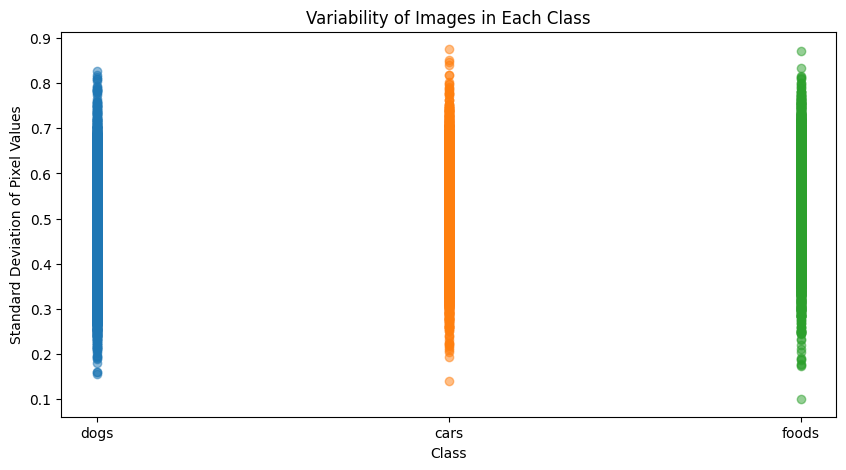

In [4]:
def plot_class_sample_variance(trainloader: DataLoader):
    classes= ['dogs','cars', 'foods']
    class_variances = {class_name: [] for class_name in classes}

    # Iterate through each image
    for images, labels in trainloader:                                     
        for i, label in enumerate(labels):
            # Calculate and append the standard deviation of the pixel value
            class_variances[classes[label]].append(images[i].std().item())

    fig, ax = plt.subplots(figsize=(10, 5))
    for class_name, variances in class_variances.items():
        ax.scatter([class_name for _ in variances], variances, alpha=0.5)

    ax.set_title('Variability of Images in Each Class')
    ax.set_xlabel('Class')
    ax.set_ylabel('Standard Deviation of Pixel Values')

    plt.show()

plot_class_sample_variance(trainloader)

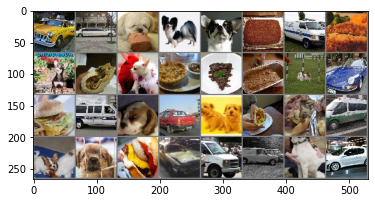

vehicles vehicles dogs  dogs  dogs  food  vehicles food  dogs  food  dogs  food  food  food  dogs  vehicles food  vehicles dogs  vehicles dogs  food  food  vehicles dogs  dogs  food  vehicles vehicles vehicles dogs  vehicles


In [7]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
# Basic building block for the ResNet18
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # Forward pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Forward pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform downsampling if not None
        if self.downsample is not None:
            residual = self.downsample(x)

        # Add the residual (shortcut connection) to the output and apply ReLU activation
        out += residual
        out = self.relu(out)
        return out

# Define the ResNet architecture


class ResNet18(nn.Module):
    def __init__(self, basicblock, dropoutAdd=False):
        super(ResNet18, self).__init__()
        self.dropoutAdd = dropoutAdd
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define layers for each stage of the network
        self.layer1 = self.buildLayer(basicblock, 64, blocks=2, stride=1)
        self.layer2 = self.buildLayer(basicblock, 128, blocks=2, stride=2)
        self.layer3 = self.buildLayer(basicblock, 256, blocks=2, stride=2)
        self.layer4 = self.buildLayer(basicblock, 512, blocks=2, stride=2)

        # Global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Dropout layer
        if self.dropoutAdd:
            self.dropout = nn.Dropout(p=0.5)
        # Fully connected layer for classification with 3 output classes
        self.fc = nn.Linear(512, 3)

    # Create a layer with multiple blocks
    def buildLayer(self, basicblock, channels, blocks, stride=1):
        downsampling = None
        if stride != 1 or self.in_channels != channels:
            # Define downsampling layers if needed
            downsample_conv = nn.Conv2d(
                self.in_channels, channels, kernel_size=1, stride=stride, bias=False)
            downsample_bn = nn.BatchNorm2d(channels)
            downsampling = nn.Sequential(downsample_conv, downsample_bn)

        # Initialize a list to store layers
        layer_blocks = [
            basicblock(self.in_channels, channels, stride, downsampling)
        ]

        # Update the number of input channels for the next block
        self.in_channels = channels

        # Create additional blocks for the layer
        layer_blocks.extend([
            basicblock(self.in_channels, channels) for _ in range(1, blocks)
        ])

        # Organize blocks into a sequential module
        seq = nn.Sequential()
        for i, layer in enumerate(layer_blocks):
            seq.add_module(f'layer_{i}', layer)

        return seq

    # Forward pass through the network
    def forward(self, x):
        # Initial convolutional and pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Forward pass through each stage of the network
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global average pooling
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # Apply dropout
        if self.dropoutAdd:
            x = self.dropout(x)
        # Fully connected layer for classification
        x = self.fc(x)
        return x

In [9]:
# Torchinfo Summary of base model
torchinfoSummary = torchinfo.summary(ResNet18(BasicBlock, dropoutAdd=False), input_data=torch.randn(
    batch_size, 3, 64, 64))  # batch_size=64, channels=3, height=64, width=64
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 32, 32]          128
├─ReLU: 1-3                              [32, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [32, 64, 16, 16]          --
├─Sequential: 1-5                        [32, 64, 16, 16]          --
│    └─BasicBlock: 2-1                   [32, 64, 16, 16]          --
│    │    └─Conv2d: 3-1                  [32, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 16, 16]          128
│    │    └─ReLU: 3-3                    [32, 64, 16, 16]          --
│    │    └─Conv2d: 3-4                  [32, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 16, 16]          128
│    │    └─ReLU: 3-6                    [32, 64, 16, 16]          --
│

In [10]:
def modelTraining(model, criterion, optimizer, earlyStopping=False, imageAug=False):
    
    train_loader = trainloader_augmented if imageAug else trainloader
    val_loader = valloader_augmented if imageAug else valloader
    test_loader = testloader_augmented if imageAug else testloader
        
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 20
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        training_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.flatten()
            loss_training = criterion(outputs, labels)
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item()

            if i % 300 == 299:
                validation_loss = 0.0
                with torch.no_grad():
                    for data in val_loader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_validation = criterion(outputs, labels)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for data in test_loader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_testing = criterion(outputs, labels)
                        testing_loss += loss_testing.item()

                training_loss = round((training_loss / 300), 3)
                validation_loss = round((validation_loss / len(val_loader)), 3)
                testing_loss = round((testing_loss / len(test_loader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                training_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 5:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [11]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [12]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC


def perfEvaluation(model, imageAug=False):
    model.eval()

    train_loader = trainloader_augmented if imageAug else trainloader
    val_loader = valloader_augmented if imageAug else valloader
    test_loader = testloader_augmented if imageAug else testloader

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=3)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

### Model with Regularization

[1, 300], Training loss: 0.554, Validation loss: 0.457, Testing loss: 0.472
[1, 600], Training loss: 0.407, Validation loss: 0.387, Testing loss: 0.412
[2, 300], Training loss: 0.365, Validation loss: 0.357, Testing loss: 0.383
[2, 600], Training loss: 0.349, Validation loss: 0.377, Testing loss: 0.42
[3, 300], Training loss: 0.333, Validation loss: 0.313, Testing loss: 0.339
[3, 600], Training loss: 0.325, Validation loss: 0.364, Testing loss: 0.386
[4, 300], Training loss: 0.297, Validation loss: 0.312, Testing loss: 0.329
[4, 600], Training loss: 0.3, Validation loss: 0.283, Testing loss: 0.314
[5, 300], Training loss: 0.286, Validation loss: 0.308, Testing loss: 0.348
[5, 600], Training loss: 0.268, Validation loss: 0.262, Testing loss: 0.301
[6, 300], Training loss: 0.248, Validation loss: 0.267, Testing loss: 0.307
[6, 600], Training loss: 0.26, Validation loss: 0.257, Testing loss: 0.284
[7, 300], Training loss: 0.229, Validation loss: 0.266, Testing loss: 0.285
[7, 600], Traini

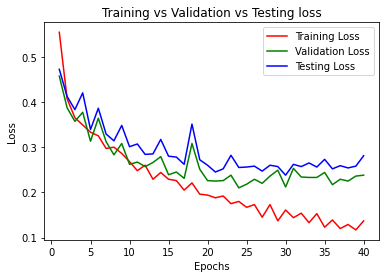

Accuracy on the testing dataset = 92.27
Precision = 0.92
Recall = 0.92
Fscore = 0.92


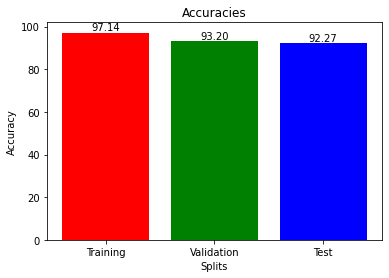

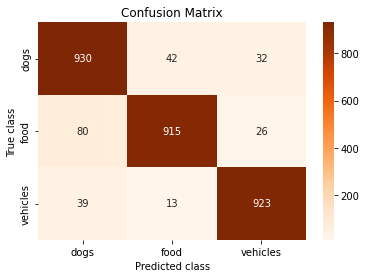

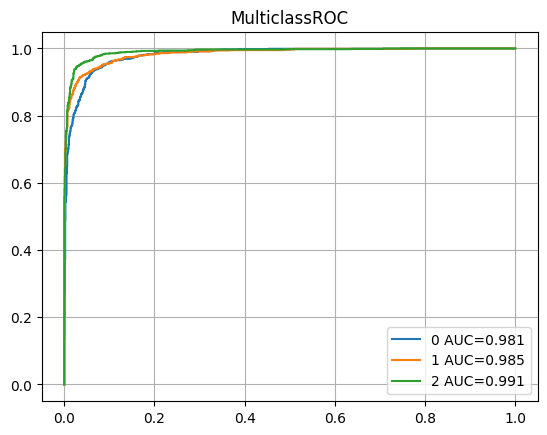

In [15]:
ResNet18_M1 = ResNet18(BasicBlock, dropoutAdd=False).to(device)

# Regularization (L2)
l2_reg = 0.001
criterion_M1 = nn.CrossEntropyLoss()
optimizer_M1 = optim.Adam(ResNet18_M1.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=ResNet18_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=ResNet18_M1, imageAug=False)

### Model with Regularization and Dropout

[1, 300], Training loss: 0.556, Validation loss: 0.418, Testing loss: 0.448
[1, 600], Training loss: 0.421, Validation loss: 0.38, Testing loss: 0.411
[2, 300], Training loss: 0.362, Validation loss: 0.324, Testing loss: 0.372
[2, 600], Training loss: 0.359, Validation loss: 0.376, Testing loss: 0.419
[3, 300], Training loss: 0.338, Validation loss: 0.324, Testing loss: 0.352
[3, 600], Training loss: 0.338, Validation loss: 0.318, Testing loss: 0.351
[4, 300], Training loss: 0.299, Validation loss: 0.282, Testing loss: 0.317
[4, 600], Training loss: 0.301, Validation loss: 0.299, Testing loss: 0.339
[5, 300], Training loss: 0.286, Validation loss: 0.285, Testing loss: 0.31
[5, 600], Training loss: 0.278, Validation loss: 0.311, Testing loss: 0.329
[6, 300], Training loss: 0.262, Validation loss: 0.26, Testing loss: 0.282
[6, 600], Training loss: 0.275, Validation loss: 0.278, Testing loss: 0.314
[7, 300], Training loss: 0.235, Validation loss: 0.25, Testing loss: 0.281
[7, 600], Traini

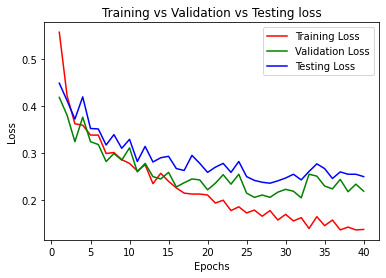

Accuracy on the testing dataset = 90.10
Precision = 0.91
Recall = 0.90
Fscore = 0.90


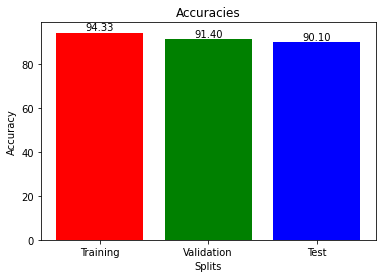

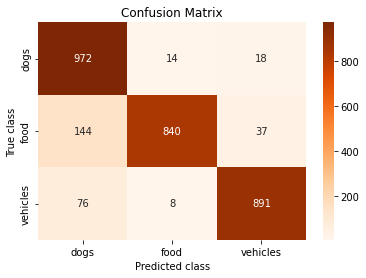

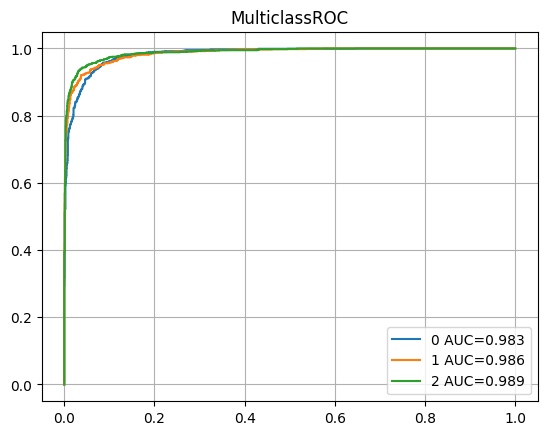

In [16]:
ResNet18_M2 = ResNet18(BasicBlock, dropoutAdd=True).to(device)

# Regularization (L2)
l2_reg = 0.001
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(ResNet18_M2.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=ResNet18_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=ResNet18_M2, imageAug=False)

### Model with Regularization, Dropout and Early Stopping

[1, 300], Training loss: 0.543, Validation loss: 0.472, Testing loss: 0.5
[1, 600], Training loss: 0.43, Validation loss: 0.379, Testing loss: 0.409
[2, 300], Training loss: 0.374, Validation loss: 0.332, Testing loss: 0.366
[2, 600], Training loss: 0.355, Validation loss: 0.365, Testing loss: 0.392
[3, 300], Training loss: 0.327, Validation loss: 0.323, Testing loss: 0.379
[3, 600], Training loss: 0.331, Validation loss: 0.313, Testing loss: 0.34
[4, 300], Training loss: 0.309, Validation loss: 0.32, Testing loss: 0.339
[4, 600], Training loss: 0.313, Validation loss: 0.306, Testing loss: 0.336
[5, 300], Training loss: 0.294, Validation loss: 0.286, Testing loss: 0.331
[5, 600], Training loss: 0.282, Validation loss: 0.286, Testing loss: 0.322
[6, 300], Training loss: 0.267, Validation loss: 0.274, Testing loss: 0.307
[6, 600], Training loss: 0.267, Validation loss: 0.267, Testing loss: 0.311
[7, 300], Training loss: 0.26, Validation loss: 0.274, Testing loss: 0.315
[7, 600], Training

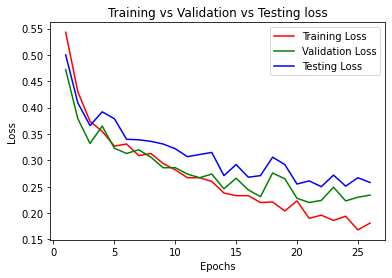

Accuracy on the testing dataset = 91.27
Precision = 0.91
Recall = 0.91
Fscore = 0.91


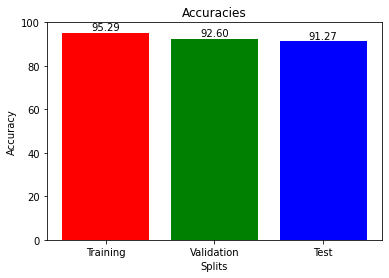

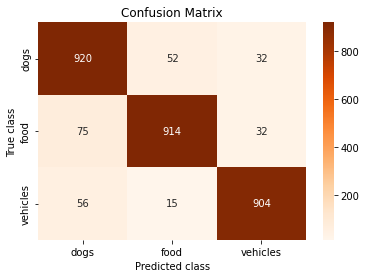

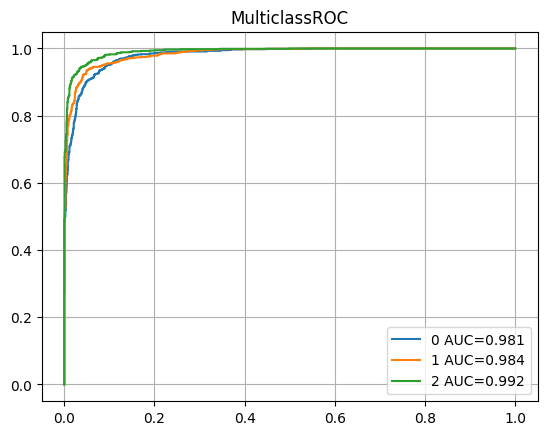

In [17]:
ResNet18_M3 = ResNet18(BasicBlock, dropoutAdd=True).to(device)

# Regularization (L2)
l2_reg = 0.001
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(ResNet18_M3.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=ResNet18_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=True, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=ResNet18_M3, imageAug=False)

### Model with Regularization, Dropout, Early Stopping and Image Augmentation

[1, 300], Training loss: 0.78, Validation loss: 0.656, Testing loss: 0.673
[1, 600], Training loss: 0.653, Validation loss: 0.65, Testing loss: 0.666
[2, 300], Training loss: 0.618, Validation loss: 0.609, Testing loss: 0.615
[2, 600], Training loss: 0.596, Validation loss: 0.593, Testing loss: 0.591
[3, 300], Training loss: 0.591, Validation loss: 0.55, Testing loss: 0.587
[3, 600], Training loss: 0.581, Validation loss: 0.597, Testing loss: 0.59
[4, 300], Training loss: 0.563, Validation loss: 0.538, Testing loss: 0.551
[4, 600], Training loss: 0.55, Validation loss: 0.533, Testing loss: 0.543
[5, 300], Training loss: 0.553, Validation loss: 0.55, Testing loss: 0.595
[5, 600], Training loss: 0.536, Validation loss: 0.572, Testing loss: 0.585
[6, 300], Training loss: 0.53, Validation loss: 0.524, Testing loss: 0.544
[6, 600], Training loss: 0.521, Validation loss: 0.511, Testing loss: 0.54
[7, 300], Training loss: 0.523, Validation loss: 0.529, Testing loss: 0.528
[7, 600], Training l

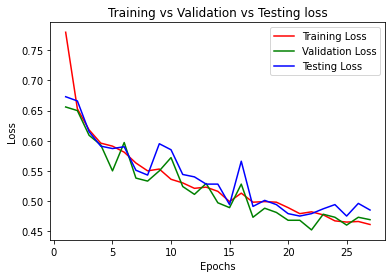

Accuracy on the testing dataset = 81.20
Precision = 0.81
Recall = 0.81
Fscore = 0.81


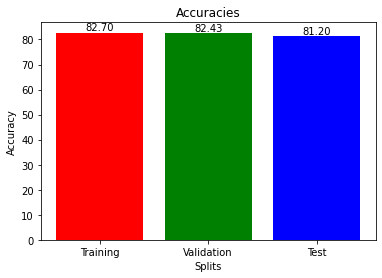

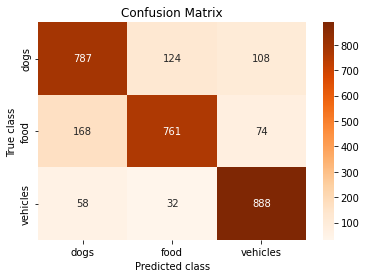

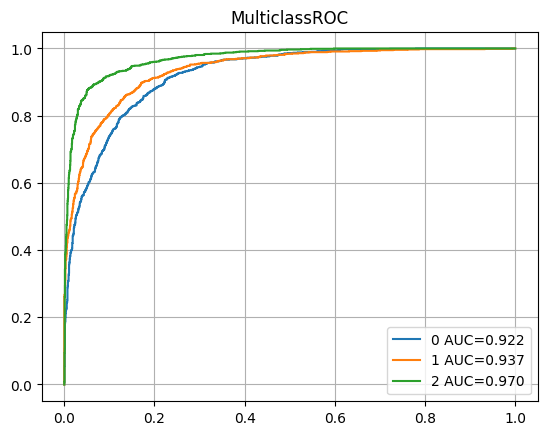

In [13]:
ResNet18_M4 = ResNet18(BasicBlock, dropoutAdd=True).to(device)

# Regularization (L2)
l2_reg = 0.001
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(ResNet18_M4.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=ResNet18_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True, imageAug=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=ResNet18_M4, imageAug=True)

### Best model weights

In [18]:
# Save model weights with best accuracy
torch.save(ResNet18_M1.state_dict(), 'ngupta22_kchavan_assignment1_part_2.pt')